In [ ]:
#import libaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling


In [ ]:
from sklearn.decomposition import PCA
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [ ]:
#from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from collections import Counter
from scipy import stats

Using TensorFlow backend.


In [ ]:
dataw=pd.read_csv("weather_data_from_plant.csv")

In [ ]:
dataw.head()

,date_time,ambient_temp,wind_speed,irradiance
0,2020-08-21T06:26:01.000Z,28.185780,0.28164,0.000000
1,2020-08-21T06:27:01.000Z,28.185780,0.28164,0.000000
2,2020-08-21T06:28:01.000Z,28.185780,0.28164,0.000000
3,2020-08-21T06:29:01.000Z,28.185780,0.28164,0.000000
4,2020-08-21T06:30:01.000Z,28.170719,0.28164,3.442247


In [ ]:
import time
import datetime
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%S.000Z").timetuple())

In [ ]:
dataw["unix_time"]=[float(convert_to_unix(x)) for x in dataw['date_time'].values]
dataw["unix_time"]=dataw["unix_time"].apply(lambda x: '%.0f' % x).astype("int")

In [ ]:
dataw["date"]=dataw["date_time"].apply(lambda x:x.split("T")[0])
dataw["year"]=dataw["date"].apply(lambda x:x.split("-")[0])
dataw["month"]=dataw["date"].apply(lambda x:x.split("-")[1])
dataw["day"]=dataw["date"].apply(lambda x:x.split("-")[2])
dataw["time"]=dataw["date_time"].apply(lambda x:x.split("T")[1].strip(".000Z"))
dataw["hr"]=dataw["time"].apply(lambda x:x.split(":")[0])
dataw["min"]=dataw["time"].apply(lambda x:x.split(":")[1])
dataw["sec"]=dataw["time"].apply(lambda x:x.split(":")[2])

In [ ]:
data=dataw[["unix_time","ambient_temp","wind_speed","irradiance"]]

In [ ]:
len(np.arange(1598016361,1603224062,60))-79912

6884

In [ ]:
len(set(np.arange(1598016361,1603224062,60))-set(data["unix_time"]))

6884

In [ ]:
miss=set(np.arange(1598016361,1603224062,60))-set(data["unix_time"])

In [ ]:
mis=[]
for i in miss:
    mis.append([i,np.nan,np.nan,np.nan])
mis=pd.DataFrame(mis,columns=data.columns)
data=data.append(mis,ignore_index=True)

In [ ]:
data=data.sort_values(by=["unix_time"],ignore_index=True)

In [ ]:
data["time_bin"]=pd.Series((np.array(data["unix_time"].values)-1598016361)//1800)


In [ ]:
data["hour"]=pd.to_datetime(data["unix_time"],unit="s").dt.hour
data["min"]=pd.to_datetime(data["unix_time"],unit="s").dt.minute
data["sec"]=pd.to_datetime(data["unix_time"],unit="s").dt.second

In [ ]:
data.head()

,unix_time,ambient_temp,wind_speed,irradiance,time_bin,hour,min,sec
0,1598016361,28.185780,0.28164,0.000000,0,13,26,1
1,1598016421,28.185780,0.28164,0.000000,0,13,27,1
2,1598016481,28.185780,0.28164,0.000000,0,13,28,1
3,1598016541,28.185780,0.28164,0.000000,0,13,29,1
4,1598016601,28.170719,0.28164,3.442247,0,13,30,1


In [ ]:
Y=data["irradiance"]
X=data.drop(["irradiance","unix_time"],axis=1)

In [ ]:
np.array(X).shape

(86796, 6)

In [ ]:
X.head()

,ambient_temp,wind_speed,time_bin,hour,min,sec
0,28.185780,0.28164,0,13,26,1
1,28.185780,0.28164,0,13,27,1
2,28.185780,0.28164,0,13,28,1
3,28.185780,0.28164,0,13,29,1
4,28.170719,0.28164,0,13,30,1


In [ ]:
Y=np.array(Y).reshape(len(Y),1)

In [ ]:
#X["wind_speed_avg"]=
draft=pd.DataFrame(X.groupby(["time_bin"]).mean()["wind_speed"])
draft["ambient_temp"]=X.groupby(["time_bin"]).mean()["ambient_temp"]
draft=draft.fillna(method="pad")
X=pd.merge(X,draft,on="time_bin")
X.ambient_temp_x.fillna(X.ambient_temp_y,inplace=True)
X.wind_speed_x.fillna(X.wind_speed_y,inplace=True)

In [ ]:
X.columns

Index(['ambient_temp_x', 'wind_speed_x', 'time_bin', 'hour', 'min', 'sec',
       'wind_speed_y', 'ambient_temp_y'],
      dtype='object')

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:

from numpy import array
from numpy import hstack
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:

generator = TimeseriesGenerator(X[[ 'ambient_temp_x', 'wind_speed_x', 'time_bin',"hour","min","sec"]], Y, length=30, batch_size=1)

In [ ]:
len(generator)

86766

In [ ]:
lisX=[]
lisY=[]
for i in range(len(generator)):
    x, y = generator[i]
    lisX.append(x.reshape(-1))
    lisY.append(y.reshape(-1))

In [ ]:
X=X[[ 'ambient_temp_x', 'wind_speed_x', 'time_bin',"hour","min","sec"]]
col=[]
for i in range(1,31):
    col.extend(X.columns+"_"+str(i))
    

In [ ]:
Xdata=pd.DataFrame(lisX,columns=col)
Ydata=pd.DataFrame(lisY)

In [ ]:
list(X.columns).extend(X.columns)

In [ ]:
X.columns

Index(['ambient_temp_x', 'wind_speed_x', 'time_bin', 'hour', 'min', 'sec'], dtype='object')

In [ ]:
Xdata.tail(10)

,ambient_temp_x_1,wind_speed_x_1,time_bin_1,hour_1,min_1,sec_1,ambient_temp_x_2,wind_speed_x_2,time_bin_2,hour_2,...,time_bin_29,hour_29,min_29,sec_29,ambient_temp_x_30,wind_speed_x_30,time_bin_30,hour_30,min_30,sec_30
86756,35.632679,0.28164,2891.0,19.0,22.0,1.0,35.662201,1.88136,2891.0,19.0,...,2892.0,19.0,50.0,1.0,36.072392,2.68122,2892.0,19.0,51.0,1.0
86757,35.662201,1.88136,2891.0,19.0,23.0,1.0,35.723141,0.28164,2891.0,19.0,...,2892.0,19.0,51.0,1.0,36.132568,0.28164,2892.0,19.0,52.0,1.0
86758,35.723141,0.28164,2891.0,19.0,24.0,1.0,35.753250,0.28164,2891.0,19.0,...,2892.0,19.0,52.0,1.0,36.133720,3.48108,2892.0,19.0,53.0,1.0
86759,35.753250,0.28164,2891.0,19.0,25.0,1.0,35.842972,1.88136,2892.0,19.0,...,2892.0,19.0,53.0,1.0,36.058460,0.28164,2892.0,19.0,54.0,1.0
86760,35.842972,1.88136,2892.0,19.0,26.0,1.0,35.812382,1.88136,2892.0,19.0,...,2892.0,19.0,54.0,1.0,36.089489,0.28164,2892.0,19.0,55.0,1.0
86761,35.812382,1.88136,2892.0,19.0,27.0,1.0,35.752960,2.68122,2892.0,19.0,...,2892.0,19.0,55.0,1.0,36.193249,0.28164,2893.0,19.0,56.0,1.0
86762,35.752960,2.68122,2892.0,19.0,28.0,1.0,35.677151,2.68122,2892.0,19.0,...,2893.0,19.0,56.0,1.0,36.253342,0.28164,2893.0,19.0,57.0,1.0
86763,35.677151,2.68122,2892.0,19.0,29.0,1.0,35.631538,1.08150,2892.0,19.0,...,2893.0,19.0,57.0,1.0,36.238201,1.88136,2893.0,19.0,58.0,1.0
86764,35.631538,1.08150,2892.0,19.0,30.0,1.0,35.586041,1.88136,2892.0,19.0,...,2893.0,19.0,58.0,1.0,36.088779,0.28164,2893.0,19.0,59.0,1.0
86765,35.586041,1.88136,2892.0,19.0,31.0,1.0,35.511669,1.08150,2892.0,19.0,...,2893.0,19.0,59.0,1.0,35.983109,0.28164,2893.0,20.0,0.0,1.0


In [ ]:
Ydata.shape,Xdata.shape


((86766, 1), (86766, 180))

In [ ]:
Xdata.columns

Index(['ambient_temp_x_1', 'wind_speed_x_1', 'time_bin_1', 'hour_1', 'min_1',
       'sec_1', 'ambient_temp_x_2', 'wind_speed_x_2', 'time_bin_2', 'hour_2',
       ...
       'time_bin_29', 'hour_29', 'min_29', 'sec_29', 'ambient_temp_x_30',
       'wind_speed_x_30', 'time_bin_30', 'hour_30', 'min_30', 'sec_30'],
      dtype='object', length=180)

In [ ]:
index_na=np.argwhere(np.array(np.isnan(Ydata)))[:,0]
Ydata_model=Ydata.drop(Ydata.index[index_na])
Xdata_model=Xdata.drop(Xdata.index[index_na])

In [ ]:
Xdata_model_train, Xdata_model_test, Ydata_model_train, Ydata_model_test = train_test_split(Xdata_model, Ydata_model, test_size=0.1, random_state=42)

In [ ]:
Xscaler = MinMaxScaler()
Xdata_model_train=Xscaler.fit_transform(Xdata_model_train)
Xdata_model_test=Xscaler.transform(Xdata_model_test)
Yscaler = MinMaxScaler()
Ydata_model_train=Yscaler.fit_transform(Ydata_model_train)
Ydata_model_test=Yscaler.transform(Ydata_model_test)

In [ ]:
Xdata_model_train=np.array(Xdata_model_train).reshape(Xdata_model_train.shape[0],30,6)
Xdata_model_test=np.array(Xdata_model_test).reshape(Xdata_model_test.shape[0],30,6)

In [ ]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.truediv(residual, total))
  return r2
init=tf.keras.initializers.HeNormal(seed=None)

def custom_lossfunction(real,pred):
    return tf.sqrt(tf.keras.losses.mean_squared_error(real, pred))
model = Sequential()
model.add(LSTM(64, activation="relu",input_shape=(30, 6),kernel_initializer=init))
model.add(Dense(1,kernel_initializer=init))
model.compile(optimizer='adam',loss=[custom_lossfunction],metrics=[R_squared])
history=model.fit(Xdata_model_train,Ydata_model_train,epochs=20,validation_data=(Xdata_model_test,Ydata_model_test))

Epoch 1/20
2247/2247 [==============================] - 76s 34ms/step - loss: 0.0569 - R_squared: 0.7433 - val_loss: 0.0523 - val_R_squared: 0.8160
Epoch 2/20
2247/2247 [==============================] - 76s 34ms/step - loss: 0.0409 - R_squared: 0.8442 - val_loss: 0.0414 - val_R_squared: 0.8384
Epoch 3/20
2247/2247 [==============================] - 76s 34ms/step - loss: 0.0378 - R_squared: 0.8511 - val_loss: 0.0364 - val_R_squared: 0.8369
Epoch 4/20
2247/2247 [==============================] - 76s 34ms/step - loss: 0.0363 - R_squared: 0.8514 - val_loss: 0.0357 - val_R_squared: 0.8505
Epoch 5/20
2247/2247 [==============================] - 75s 33ms/step - loss: 0.0359 - R_squared: 0.8507 - val_loss: 0.0384 - val_R_squared: 0.8424
Epoch 6/20
2247/2247 [==============================] - 75s 33ms/step - loss: 0.0349 - R_squared: 0.8538 - val_loss: 0.0363 - val_R_squared: 0.8409
Epoch 7/20
2247/2247 [==============================] - 75s 33ms/step - loss: 0.0344 - R_squared: 0.8554 - val_l

In [ ]:
model.layers[0]

In [ ]:
model.save("weather.h5")

In [ ]:
predicted_train=model.predict(Xdata_model_train)

In [ ]:
scaler.inverse_transform(predicted_train),scaler.inverse_transform(Ydata_model_train)

(array([[318.60364  ],
        [  1.7019879],
        [838.96344  ],
        ...,
        [200.04504  ],
        [  1.4152576],
        [ 13.303018 ]], dtype=float32),
 array([[346.4760132 ],
        [  0.        ],
        [897.7489014 ],
        ...,
        [282.2380981 ],
        [  0.        ],
        [ 19.04986954]]))

In [ ]:
predicted_train,Ydata_model_train

(array([[0.23242727],
        [0.00124163],
        [0.61203945],
        ...,
        [0.14593658],
        [0.00103246],
        [0.0097048 ]], dtype=float32),
 array([[0.2527607 ],
        [0.        ],
        [0.65492452],
        ...,
        [0.20589794],
        [0.        ],
        [0.01389723]]))

In [ ]:
model.save_weights("weather_weights.h5")

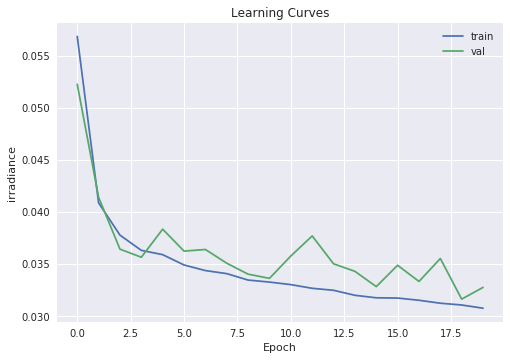

In [ ]:
import matplotlib.pyplot as plt
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('irradiance')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()


In [ ]:
history=model.fit(Xdata_model_train,Ydata_model_train,epochs=20,validation_data=(Xdata_model_test,Ydata_model_test))

Epoch 1/20
2247/2247 [==============================] - 74s 33ms/step - loss: 0.0305 - R_squared: 0.8694 - val_loss: 0.0323 - val_R_squared: 0.8440
Epoch 2/20
2247/2247 [==============================] - 74s 33ms/step - loss: 0.0303 - R_squared: 0.8681 - val_loss: 0.0306 - val_R_squared: 0.8678
Epoch 3/20
2247/2247 [==============================] - 74s 33ms/step - loss: 0.0301 - R_squared: 0.8690 - val_loss: 0.0313 - val_R_squared: 0.8715
Epoch 4/20
2247/2247 [==============================] - 74s 33ms/step - loss: 0.0299 - R_squared: 0.8701 - val_loss: 0.0320 - val_R_squared: 0.8525
Epoch 5/20
2247/2247 [==============================] - 74s 33ms/step - loss: 0.0300 - R_squared: 0.8710 - val_loss: 0.0367 - val_R_squared: 0.8415
Epoch 6/20
2247/2247 [==============================] - 74s 33ms/step - loss: 0.0298 - R_squared: 0.8719 - val_loss: 0.0314 - val_R_squared: 0.8559
Epoch 7/20
2247/2247 [==============================] - 74s 33ms/step - loss: 0.0295 - R_squared: 0.8704 - val_l

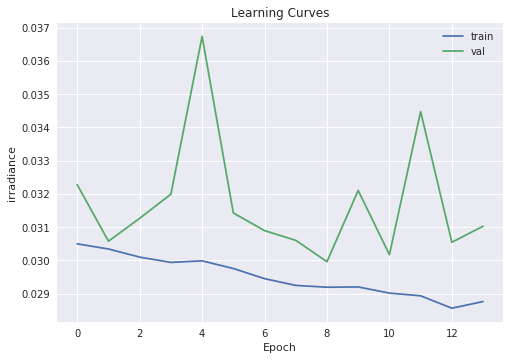

In [ ]:
import matplotlib.pyplot as plt
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('irradiance')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()


In [ ]:
scaler.inverse_transform(predicted_train),scaler.inverse_transform(Ydata_model_train)

(array([[318.60364  ],
        [  1.7019879],
        [838.96344  ],
        ...,
        [200.04504  ],
        [  1.4152576],
        [ 13.303018 ]], dtype=float32),
 array([[346.4760132 ],
        [  0.        ],
        [897.7489014 ],
        ...,
        [282.2380981 ],
        [  0.        ],
        [ 19.04986954]]))

In [ ]:
predicted_train,Ydata_model_train

(array([[0.23242727],
        [0.00124163],
        [0.61203945],
        ...,
        [0.14593658],
        [0.00103246],
        [0.0097048 ]], dtype=float32),
 array([[0.2527607 ],
        [0.        ],
        [0.65492452],
        ...,
        [0.20589794],
        [0.        ],
        [0.01389723]]))

/home/u50953/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


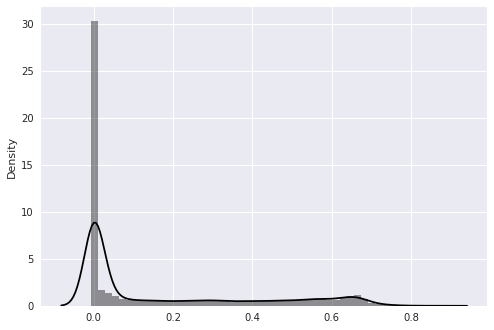

In [ ]:
#plt.hist(Ydata_model_train,color="r")
sns.distplot(predicted_train,color="black")

/home/u50953/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


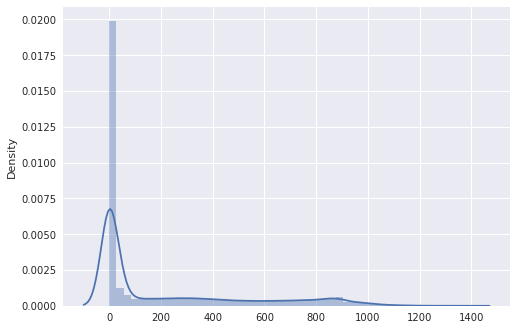

In [ ]:
sns.distplot(scaler.inverse_transform(Ydata_model_train))

In [ ]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.truediv(residual, total))
  return r2
init=tf.keras.initializers.HeNormal(seed=None)

def custom_lossfunction(real,pred):
    return tf.sqrt(tf.keras.losses.mean_squared_error(real, pred))
model = Sequential()
model.add(LSTM(64, activation="relu",input_shape=(30, 6),kernel_initializer=init))
model.add(Dense(1,kernel_initializer=init))
model.compile(optimizer='adam',loss=[custom_lossfunction],metrics=[R_squared])
history=model.fit(Xdata_model_train,Ydata_model_train,epochs=100,batch_size=512,validation_data=(Xdata_model_test,Ydata_model_test))

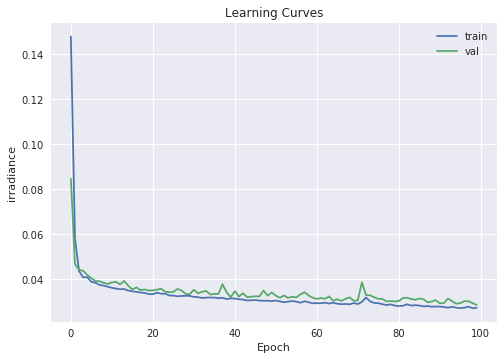

In [ ]:
import matplotlib.pyplot as plt
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('irradiance')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()


In [ ]:
model.save("weather_v2.h5")

In [ ]:
pred=model.predict(Xdata_model_train)

In [ ]:
scaler.inverse_transform(pred),scaler.inverse_transform(Ydata_model_train)

(array([[ 2.7218506e+02],
        [-4.1899383e-01],
        [ 8.8061365e+02],
        ...,
        [ 5.4917517e+02],
        [ 1.2860901e+01],
        [ 1.1271797e+01]], dtype=float32),
 array([[346.4760132 ],
        [  0.        ],
        [897.7489014 ],
        ...,
        [282.2380981 ],
        [  0.        ],
        [ 19.04986954]]))

In [ ]:
model.save("weather_v3.h5")